In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import HTML

from collab2.foraging.toolkit import (
    animate_predictors,
    constraint_filter_nearest,
    dataObject,
    generate_local_windows,
    plot_predictor,
    rescale_to_grid,
    subsample_frames_constant_frame_rate,
)
from collab2.foraging.toolkit.point_contribution import _point_contribution
from collab2.foraging.toolkit.proximity import (
    _generate_proximity_predictor,
    _piecewise_proximity_function,
    generate_proximity_predictor,
)

In [2]:
# create a test object with random data
num_frames = 8
num_foragers = 4
grid_size = 30
n_nans = int(num_frames * num_foragers / 5)
n_missing = int(num_frames * num_foragers / 5)
gridMin = -1
gridMax = 1

np.random.seed(42)

# generate data in a unit disk
theta = 2 * np.pi * np.random.rand(num_frames * num_foragers)
r = np.random.rand(num_frames * num_foragers)

data = {
    "x": r * np.cos(theta),
    "y": r * np.sin(theta),
    "time": np.tile(np.arange(num_frames), num_foragers),
    "forager": np.concatenate([i * np.ones(num_frames) for i in range(num_foragers)]),
}

foragersDF = pd.DataFrame(data)

foragersDF_scaled = rescale_to_grid(
    foragersDF, size=grid_size, gridMin=gridMin, gridMax=gridMax
)
foragers_object = dataObject(foragersDF_scaled, grid_size=grid_size)

In [3]:
# get local windows
local_windows_kwargs = {
    "window_size": 10,
    "sampling_fraction": 1,
    "skip_incomplete_frames": False,
}

foragers_object.local_windows_kwargs = local_windows_kwargs

local_windows = generate_local_windows(foragers_object)

In [4]:
times = foragers_object.foragersDF["time"].unique()

rewards = []
for time in times:
    rewards.append(
        pd.DataFrame(
            {
                "x": [16, 13],
                "y": [13, 10],
            }
        )
    )

print(len(rewards))

print(rewards[0])

foragers_object.rewards = rewards

8
    x   y
0  16  13
1  13  10


In [5]:
from collab2.foraging.toolkit import filter_by_distance

f = 2
t = 1
L = 15
filter_by_distance(foragers_object.foragersDF, f=f, t=t, interaction_length=L)

[1.0, 3.0]

In [6]:
from collab2.foraging.toolkit.filtering import constraint_filter_close_to_reward

outcome = filter_by_distance(
    foragers_object.foragersDF,
    f=f,
    t=t,
    interaction_length=L,
    interaction_constraint= constraint_filter_close_to_reward,
    grid_size=foragers_object.grid_size,
    finders_tolerance=2,
    time_lag=1,
    rewards=foragers_object.rewards,
)

print(outcome)

[3]


In [7]:
from collab2.foraging.toolkit.communication import _generate_communication_predictor

interaction_constraint_params = {
"finders_tolerance": 4.,
"time_lag": 1,
'grid_size': foragers_object.grid_size
}

ppr = _generate_communication_predictor(
    foragers=foragers_object.foragers,
    foragersDF= foragers_object.foragersDF,
    rewards = foragers_object.rewards,
    #grid_size = foragers_object.grid_size,
    #finders_tolerance = 4.,
    #time_lag = 1,
    interaction_length= 15,
    interaction_constraint_params= interaction_constraint_params,
    predictor_name="pred",
    local_windows=local_windows,
    decay_factor=0.2,

)

In [8]:
display(ppr)

[[      x   y  distance_to_forager  time  forager      pred
  135   4  15            10.000000     0        0  0.193673
  161   5  11             9.848858     0        0  0.215137
  162   5  12             9.486833     0        0  0.227789
  163   5  13             9.219544     0        0  0.235938
  164   5  14             9.055385     0        0  0.238754
  ..   ..  ..                  ...   ...      ...       ...
  706  23  16             9.055385     0        0  0.154413
  707  23  17             9.219544     0        0  0.147332
  708  23  18             9.486833     0        0  0.138180
  709  23  19             9.848858     0        0  0.127566
  735  24  15            10.000000     0        0  0.130323
  
  [317 rows x 6 columns],
        x   y  distance_to_forager  time  forager      pred
  550  18  10            10.000000     1        0  1.000000
  576  19   6             9.848858     1        0  0.486212
  577  19   7             9.486833     1        0  0.571486
  578  19  

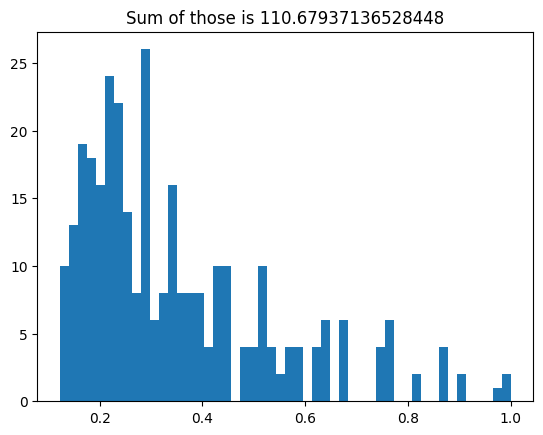

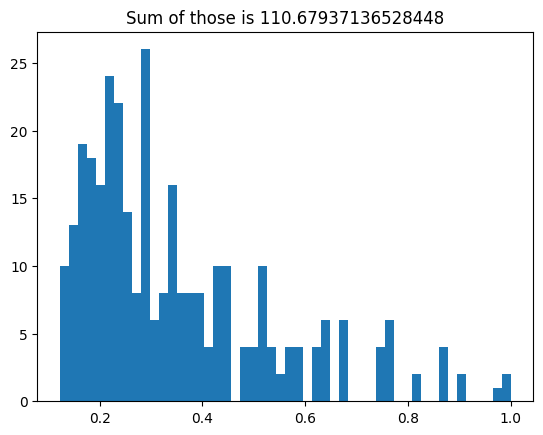

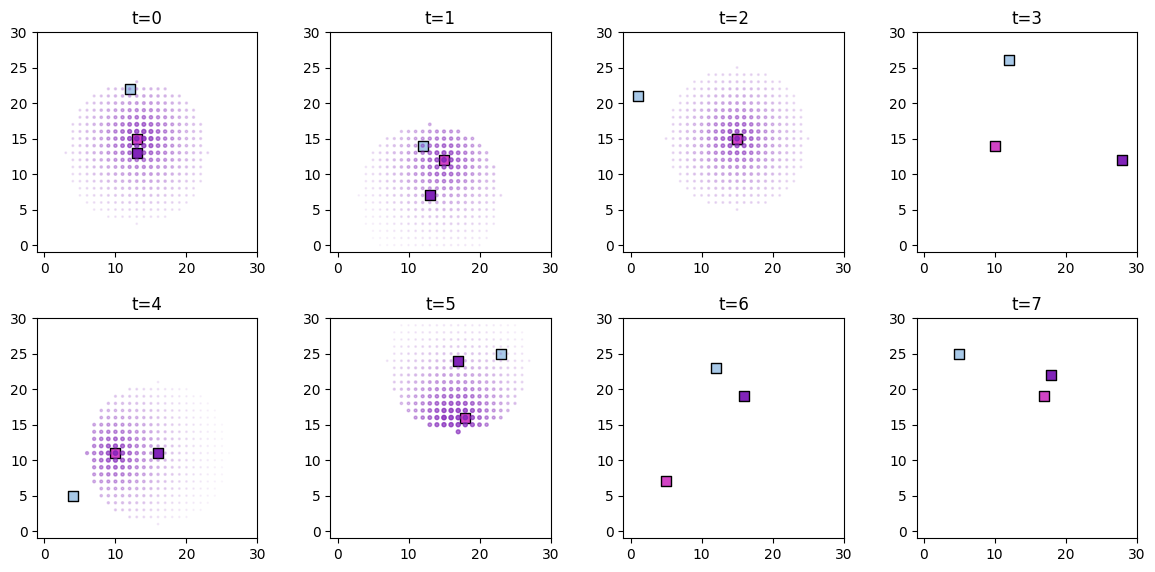

In [10]:

ppr_non_null = ppr[0][0]["pred"][ppr[0][0]["pred"] > 0.01]

plt.hist(ppr[0][0]["pred"], bins=50)
plt.title(f"Sum of those is {ppr[0][0]['pred'].abs().sum()}")
plt.show()

plt.hist(ppr_non_null, bins=50)
plt.title(f"Sum of those is {ppr_non_null.abs().sum()}")
plt.show()


plot_predictor(
    foragers_object.foragers,
    ppr,
    "pred",
    forager_position_indices=[1,2,3],
    forager_predictor_indices=[1],
    time=range(num_frames),
    grid_size=grid_size,
    size_multiplier=10,
    random_state=99,
)

In [ ]:
ani = animate_predictors(
    foragers_object.foragersDF,
    ppr,
    predictor_name="pred",
    forager_position_indices=[0,1,2, 3],
    forager_predictor_indices=[0, 1, 2,  3],
    grid_size=grid_size,
    random_state=10,
    size_multiplier=10,
)
HTML(ani.to_jshtml())